In [9]:
#PARAMETERS
symbols = ['AMD', 'CLX']
train_start_date = '2019-11-30'
train_end_date = '2021-11-15'
N = 30 #number of previous days to observe

In [10]:
import yfinance as yf
import pandas as pd
close_prices = yf.download(symbols, train_start_date, train_end_date)['Close']
market_series = yf.download('SYN', train_start_date, train_end_date)['Close']

print(close_prices.shape)
print(close_prices.head())
print(len(close_prices))

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
(494, 2)
                  AMD         CLX
Date                             
2019-11-29  39.150002  148.229996
2019-12-02  38.730000  148.929993
2019-12-03  38.900002  147.949997
2019-12-04  39.689999  150.300003
2019-12-05  39.619999  150.789993
494


## 3-state labeling

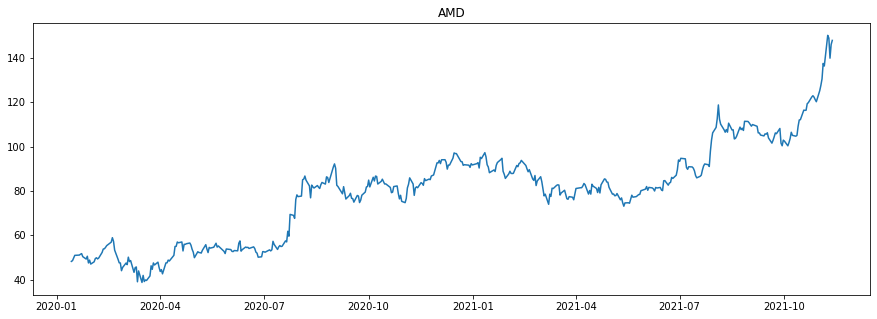

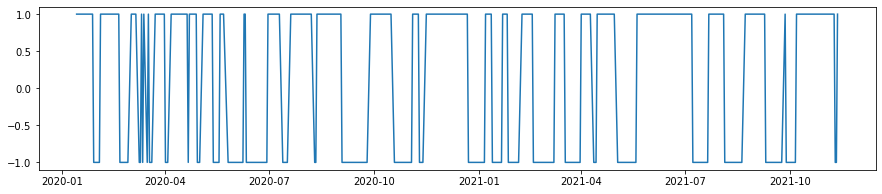

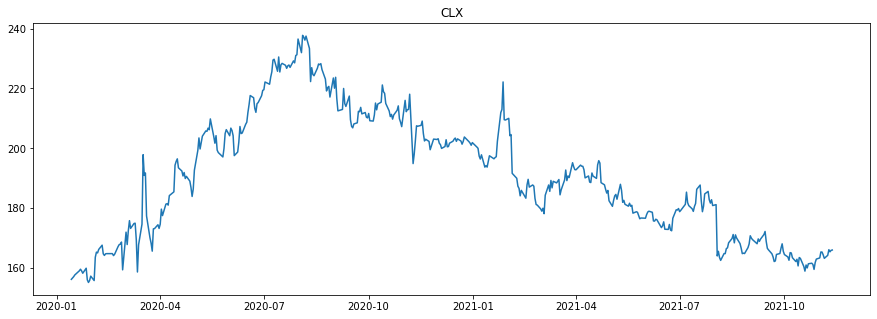

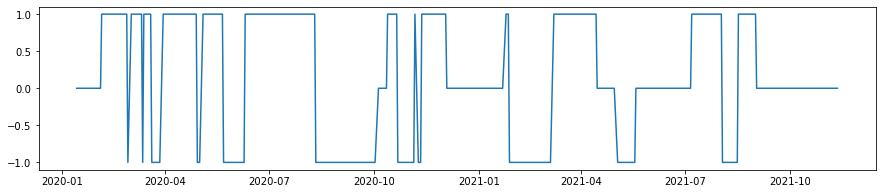

In [12]:
import labeling_algorithm
import matplotlib.pyplot as plt

prices_for_labeling = close_prices[N:]

labels_df = pd.DataFrame({'Date': prices_for_labeling.index})

for stock in symbols:
    labels = labeling_algorithm.get_series_labels(prices_for_labeling[stock], 0.05, 11)

    labels_df[stock] = labels

    plt.figure(figsize=(15, 5), facecolor='w')
    plt.plot(labels_df['Date'], prices_for_labeling[stock])
    plt.title(stock)
    plt.show()
    plt.figure(figsize=(15, 3), facecolor='w')
    plt.plot(labels_df['Date'], labels_df[stock])
    plt.show()

labels_df = labels_df.set_index('Date')

## 2-state labeling

Samo trenutno tu za usporedbu s 3-state labeling lagoritmom

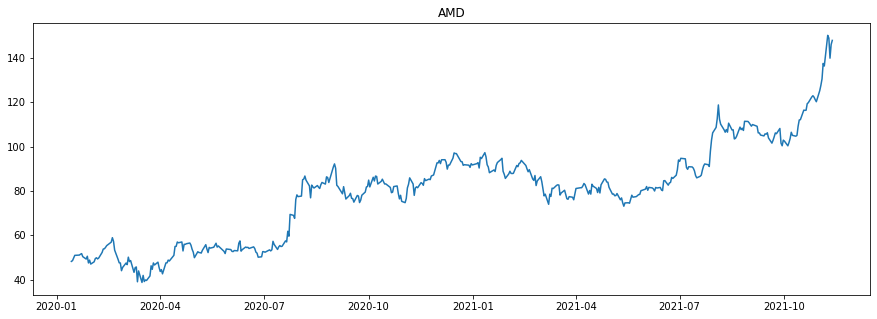

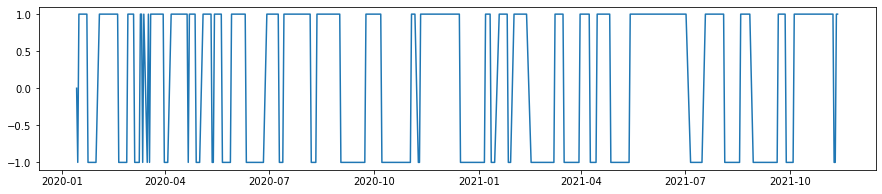

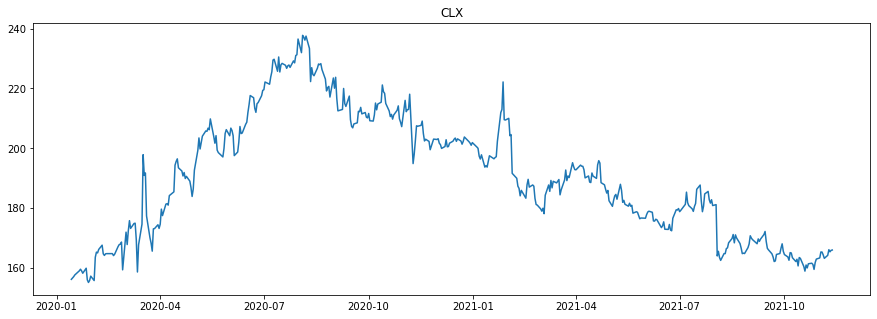

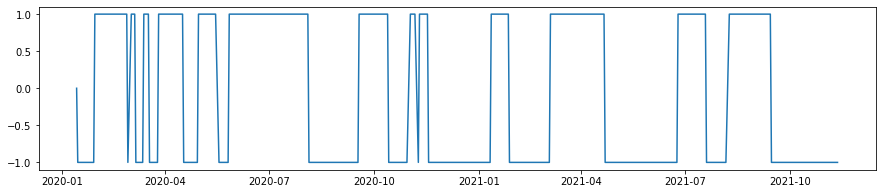

In [13]:
import la2
import matplotlib.pyplot as plt

for stock in symbols:
    labels = la2.get_series_labels(prices_for_labeling[stock], 0.05)

    plt.figure(figsize=(15, 5), facecolor='w')
    plt.plot(prices_for_labeling.index, prices_for_labeling[stock])
    plt.title(stock)
    plt.show()
    plt.figure(figsize=(15, 3), facecolor='w')
    plt.plot(prices_for_labeling.index, labels)
    plt.show()

## Features

In [14]:
from features_util import compute_features, get_available_features
features = get_available_features()
#create 2-lavel column dataframe, first level is stock symbol, second level is feature name
features_df = pd.DataFrame(columns = pd.MultiIndex.from_product([symbols, features]))

for stock in symbols:
    features_df[stock] = compute_features(stock, close_prices[stock], market_series, N)

features_df = features_df.set_index(close_prices[N:].index)

print(features_df.head(2))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
              AMD                                                              \
              Min        Max    Mean       Std  Skewness  Kurtosis Chi-Square   
Date                                                                            
2020-01-14  38.73  49.099998  43.865  3.755966 -0.016605 -1.585665   2.915860   
2020-01-15  38.73  49.099998  44.167  3.727913 -0.144715 -1.557263   2.918515   

                                           CLX                          \
                Beta   Mean_Volume         Min         Max        Mean   
Date                                                                     
2020-01-14 -0.016404  4.893953e+07  147.949997  156.199997  151.923999   
2020-01-15 -0.035836  4.963797e+07  147.949997  156.250000  152.191332   

                                                                              
      

## 10-fold corss validation

In [15]:
from cross_validation import ten_fold_cv_selection, CV

#combine features, labels_df and mark data for cross validation
data_df = features_df.copy()
for stock in symbols:
    data_df[stock, 'Label'] = labels_df[stock]

cv_data_list = ten_fold_cv_selection(data_df, N)


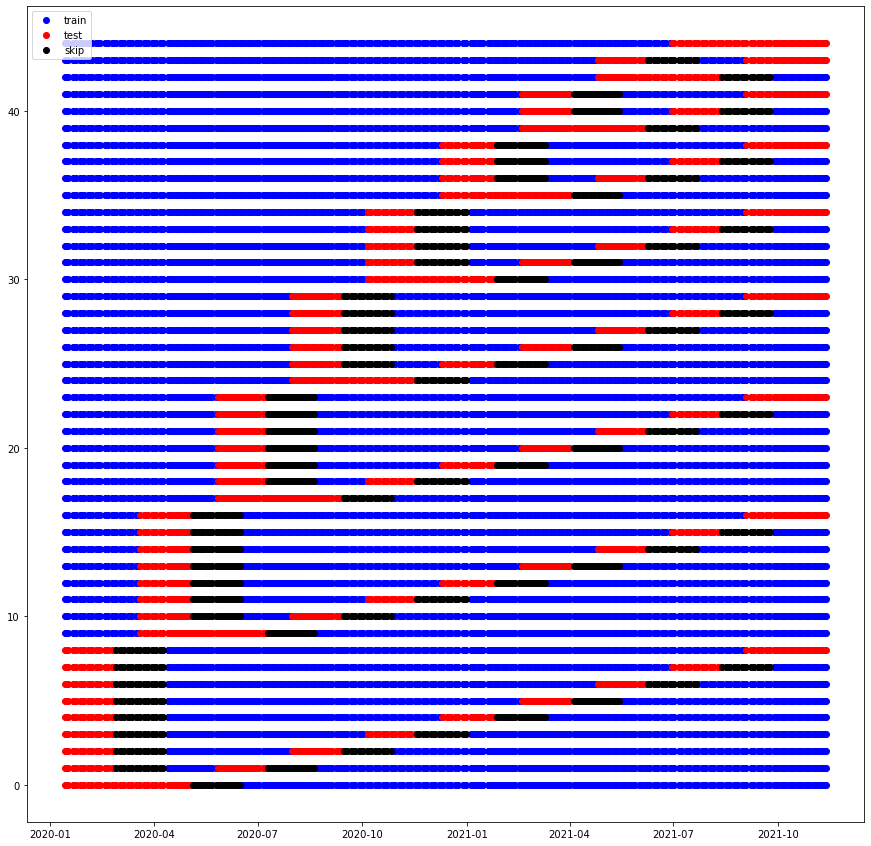

In [16]:
plt.figure(figsize=(15, 15), facecolor='w')
for i in range(len(cv_data_list)):
    df = cv_data_list[i]['CV'].reset_index()
    t = df[df['CV'] == CV.train]['Date']
    plt.plot(t, [i]*len(t), 'bo')
    t = df[df['CV'] == CV.test]['Date']
    plt.plot(t, [i]*len(t), 'ro')
    t = df[df['CV'] == CV.skip]['Date']
    plt.plot(t, [i]*len(t), 'ko')

plt.legend(['train', 'test', 'skip'])
plt.show()
